**Import Modules**

In [1]:
from scidx.client import sciDXClient, TimeDirection
import numpy as np
import matplotlib.pyplot as plt

**API Socket and Credentials**

In [2]:
api_url="https://dataspaces.ndp.utah.edu/pop"

**Establish server connection**

In [3]:
# Initialize the client
client = sciDXClient(api_url)

**Search Parameters** - parameters that identify the resource or resources being staged. The user provides a `source` dataset (the RadC dataset for the GOES-18 satellite, in this case), a nearest `timestamp` and a direction in time to search (i.e. the nearest available data to `timestamp` in the `PAST` or `FUTURE`).

In [4]:
source = 'goes18-radc'
timestamp = '2024-08-02T00:35:00'
time_direction = TimeDirection.PAST

**Subsetting Parameters** - parameters that guide the server-side subsetting of matching data. In this case, the user gives a `var_name`, which specifies the array inside the resource to subset, and lower- and upper- bound indices. These parameters are interpreted by resource type-specific handler module in DataSpaces, which is chosen based on prior registration parameters.

In [5]:
var_name = 'Rad'
lb = (0,2500)
ub = (1499,4999)

**Query** - search for resources, do a server-side download and subset, receive the results.

In [6]:
result = client.query_array(source=source,
                       var_name=var_name,
                       lb=lb, 
                       ub=ub, 
                       timestamp=timestamp,
                       time_direction=time_direction)

**Handle results** - the return value is a list of tuples, one per found resource.

In [7]:
(radiance, res_tstamp, res_metadata) = result[0]
print(res_tstamp, res_metadata)

2024-08-02 00:31:18 {'channel': '3', 'file_type': 'NetCDF', 'source': 'goes18-radc', 'timestamp': '2024-08-02T00:31:18'}


### Visualize Results

In [8]:
def viz_radiance(radiance):
    # Define some constants needed for the conversion. From the pdf linked above
    Esun_Ch_01 = 726.721072
    Esun_Ch_02 = 663.274497
    Esun_Ch_03 = 441.868715
    d2 = 0.3
    # Apply the formula to convert radiance to reflectance
    ref = (radiance * np.pi * d2) / Esun_Ch_02

    # Make sure all data is in the valid data range
    ref = np.maximum(ref, 0.0)
    ref = np.minimum(ref, 1.0)

    # Apply the formula to adjust reflectance gamma
    ref_gamma = np.sqrt(ref)

    # Plot gamma adjusted reflectance
    fig = plt.figure(figsize=(4,4),dpi=200)
    im = plt.imshow(ref_gamma, vmin=0.0, vmax=1.0, cmap='Greys_r')
    cb = fig.colorbar(im, orientation='horizontal')
    cb.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    cb.set_label('Reflectance')
    plt.show()

### Generate Visualization
West Coast radiance visualization

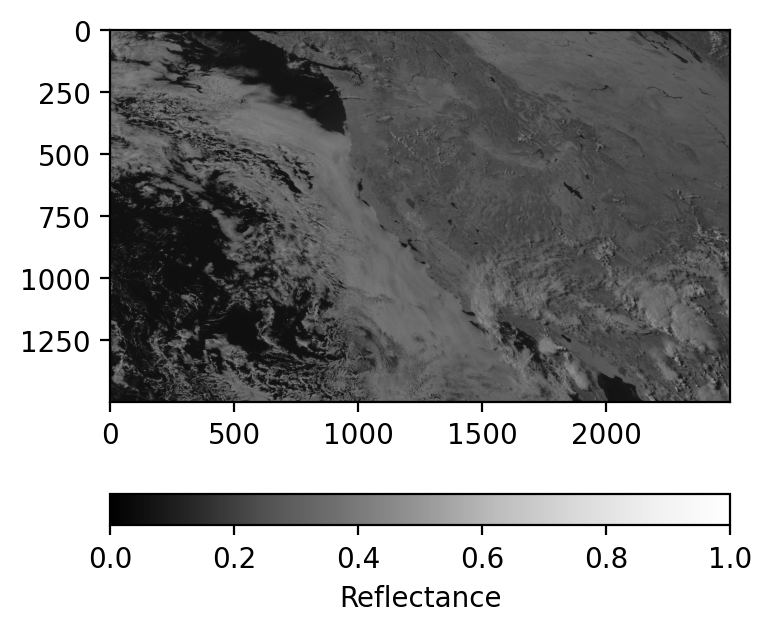

In [9]:
viz_radiance(radiance)

### Change the time direction
Query with the same `timestamp`, but ask for the next nearest `FUTURE` result.

In [10]:
result = client.query_array(source=source,
                       var_name=var_name,
                       lb=lb, 
                       ub=ub, 
                       timestamp=timestamp,
                       time_direction=TimeDirection.FUTURE)
(radiance, res_tstamp, res_metadata) = result[0]
print(res_tstamp, res_metadata)

2024-08-02 00:36:18 {'channel': '3', 'file_type': 'NetCDF', 'source': 'goes18-radc', 'timestamp': '2024-08-02T00:36:18'}


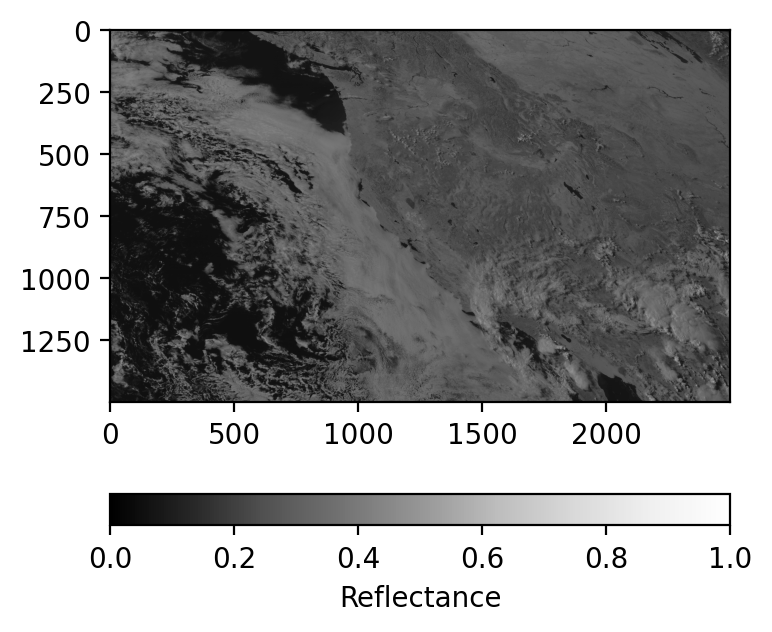

In [11]:
viz_radiance(radiance)

### Query for all the resources within a time range
Query a 15 minute interval

In [12]:
start_time='2024-08-02T00:30:00'
end_time='2024-08-02T00:45:00'
results = client.query_array(source=source,
                       var_name=var_name,
                       lb=lb, 
                       ub=ub, 
                       start_time=start_time,
                       end_time=end_time)

In [13]:
for result in results:
    (radiance, res_tstamp, res_metadata) = result
    print(res_tstamp, res_metadata)

2024-08-02 00:31:18 {'channel': '3', 'file_type': 'NetCDF', 'source': 'goes18-radc', 'timestamp': '2024-08-02T00:31:18'}
2024-08-02 00:36:18 {'channel': '3', 'file_type': 'NetCDF', 'source': 'goes18-radc', 'timestamp': '2024-08-02T00:36:18'}
2024-08-02 00:41:18 {'channel': '3', 'file_type': 'NetCDF', 'source': 'goes18-radc', 'timestamp': '2024-08-02T00:41:18'}


### Print result metadata
RadC produces data every 5 minutes, so we see three results in our 15 minute interval.